In [1]:
from torchvision import datasets

train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=True)

In [2]:
import matplotlib.pyplot as plt

In [3]:
train_val_dataset, test_dataset
class_names = train_val_dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Text(0.5, 1.0, '3 - three')

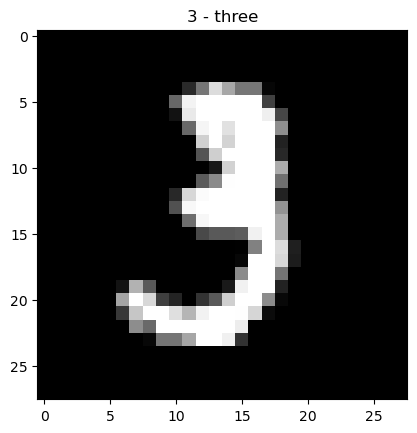

In [4]:
img, label = train_val_dataset[10]
img, label
plt.imshow(img, cmap='gray')
plt.title(f"{class_names[label]}")

In [5]:
import numpy as np

# def img_pixel_superimpose(img, ax):
#     w, h = img.shape
#     color_map = plt.cm.get_cmap('gray_r')  # gray_reversed
#     ax.imshow(img, cmap='gray')
#     for x in range(w):
#         for y in range(h):
#             color = color_map(img[x][y])
#             ax.annotate(str(img[x][y]), xy=(y,x), horizontalalignment='center', verticalalignment='center',
#                         color=color)
#             plt.axis(False)

In [6]:
import torch

# torch.manual_seed(42)

# fig = plt.figure(figsize = (12,12)) 
# ax0 = fig.add_subplot(1, 1, 1)

# rand_ind = torch.randint(0, len(train_val_dataset), size=[1]).item()

# img0 = train_val_dataset.data[rand_ind]
# img0 = img0.numpy()
# img_pixel_superimpose(img0, ax0)

In [7]:
from torchvision import transforms

train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=False, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="./datasets", train=False, download=False, transform=transforms.ToTensor())

In [8]:
mnist_transforms = transforms.Compose([transforms.ToTensor()])#,
                                        #transforms.Normalize(mean=mean, std=std)])

In [9]:
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=False, transform=mnist_transforms)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=False, transform=mnist_transforms)
train_val_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./datasets/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./datasets/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

In [10]:
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
len(train_dataset), len(val_dataset), len(test_dataset)

(54000, 6000, 10000)

In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Let's see no of batches that we have now with the current batch-size
len(train_dataloader), len(val_dataloader), len(test_dataloader) 

(1688, 188, 313)

In [12]:
from torch import nn

class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.feature(x))
    
#model_lenet5v1 = LeNet5V1()

In [17]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_lenet5v1.parameters(), lr=0.001)
accuracy = Accuracy(task='multiclass', num_classes=10)

NameError: name 'model_lenet5v1' is not defined

In [78]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import os

# Experiment tracking
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = "MNIST"
model_name = "LeNet5V1"
log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
writer = SummaryWriter(log_dir)

# device-agnostic setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
accuracy = accuracy.to(device)
model_lenet5v1 = model_lenet5v1.to(device)

EPOCHS = 12

for epoch in tqdm(range(EPOCHS)):
    # Training loop
    train_loss, train_acc = 0.0, 0.0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        model_lenet5v1.train()
        
        y_pred = model_lenet5v1(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        acc = accuracy(y_pred, y)
        train_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
        
    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    model_lenet5v1.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model_lenet5v1(X)
            
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            
            acc = accuracy(y_pred, y)
            val_acc += acc
            
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        
    writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss, "val/loss": val_loss}, global_step=epoch)
    writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc, "val/acc": val_acc}, global_step=epoch)
    
    print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")

  8%|▊         | 1/12 [00:17<03:08, 17.16s/it]

Epoch: 0| Train loss:  0.25219| Train acc:  0.92532| Val loss:  0.11339| Val acc:  0.96692


 17%|█▋        | 2/12 [00:34<02:54, 17.41s/it]

Epoch: 1| Train loss:  0.08570| Train acc:  0.97397| Val loss:  0.08494| Val acc:  0.97207


 25%|██▌       | 3/12 [00:51<02:36, 17.34s/it]

Epoch: 2| Train loss:  0.06024| Train acc:  0.98123| Val loss:  0.06433| Val acc:  0.98055


 33%|███▎      | 4/12 [01:09<02:20, 17.52s/it]

Epoch: 3| Train loss:  0.04598| Train acc:  0.98595| Val loss:  0.06001| Val acc:  0.98471


 42%|████▏     | 5/12 [01:27<02:02, 17.52s/it]

Epoch: 4| Train loss:  0.03856| Train acc:  0.98787| Val loss:  0.04975| Val acc:  0.98587


 50%|█████     | 6/12 [01:44<01:44, 17.45s/it]

Epoch: 5| Train loss:  0.03065| Train acc:  0.99035| Val loss:  0.05323| Val acc:  0.98487


 58%|█████▊    | 7/12 [02:02<01:27, 17.55s/it]

Epoch: 6| Train loss:  0.02667| Train acc:  0.99174| Val loss:  0.05250| Val acc:  0.98521


 67%|██████▋   | 8/12 [02:20<01:10, 17.59s/it]

Epoch: 7| Train loss:  0.02250| Train acc:  0.99319| Val loss:  0.05369| Val acc:  0.98587


 75%|███████▌  | 9/12 [02:42<00:57, 19.13s/it]

Epoch: 8| Train loss:  0.02010| Train acc:  0.99339| Val loss:  0.05088| Val acc:  0.98720


 83%|████████▎ | 10/12 [03:07<00:41, 20.83s/it]

Epoch: 9| Train loss:  0.01860| Train acc:  0.99365| Val loss:  0.04942| Val acc:  0.98670


 92%|█████████▏| 11/12 [03:25<00:20, 20.08s/it]

Epoch: 10| Train loss:  0.01537| Train acc:  0.99463| Val loss:  0.05700| Val acc:  0.98388


100%|██████████| 12/12 [03:44<00:00, 18.68s/it]

Epoch: 11| Train loss:  0.01261| Train acc:  0.99596| Val loss:  0.05324| Val acc:  0.98670


In [13]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet5_v1_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving the model
#print(f"Saving the model: {MODEL_SAVE_PATH}")
#torch.save(obj=model_lenet5v1.state_dict(), f=MODEL_SAVE_PATH)

# Loading the saved model
model_lenet5_v1_mnist_loaded = LeNet5V1()
model_lenet5_v1_mnist_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

C:\Users\jsve\AppData\Local\Temp\ipykernel_20824\2652600245.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_lenet5_v1_mnist_loaded.load_state_dict(torch.load(MODE

<All keys matched successfully>

In [14]:
from torchmetrics import Accuracy


device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_fn = nn.CrossEntropyLoss()
accuracy = Accuracy(task='multiclass', num_classes=10)

test_loss, test_acc = 0, 0

model_lenet5_v1_mnist_loaded.to(device)

model_lenet5_v1_mnist_loaded.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model_lenet5_v1_mnist_loaded(X)
        
        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)
        
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

Test loss:  0.04977| Test acc:  0.98612


c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


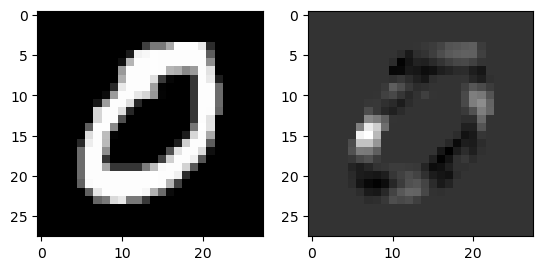

In [15]:
from captum.attr import IntegratedGradients

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(10)

random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
img, label = test_dataset[random_idx]
img = img.to(device)

# Instantiate an IntegratedGradients object for the model
ig = IntegratedGradients(model_lenet5_v1_mnist_loaded)

# Compute the attribution scores for the random image
attr, delta = ig.attribute(img.unsqueeze(0), target=label, return_convergence_delta=True)

# Visualize the attribution scores
fig, ax = plt.subplots(1, 2)

ax[0].imshow(img.permute(1, 2, 0).to('cpu'), cmap='gray')
ax[1].imshow(attr[0][0].detach().to('cpu').numpy(), cmap='gray')

In [34]:
##c1 8, c2 2 

class1 = 1
class1_ind = []
imgs_c1 = []
class2 = 0
class2_ind = []
imgs_c2 = []

ind = 0
for sample in test_dataset:
    s,c = sample
    if c == class1:
        class1_ind.append(ind)
        imgs_c1.append(s)
    elif c == class2:
        class2_ind.append(ind)
        imgs_c2.append(s)

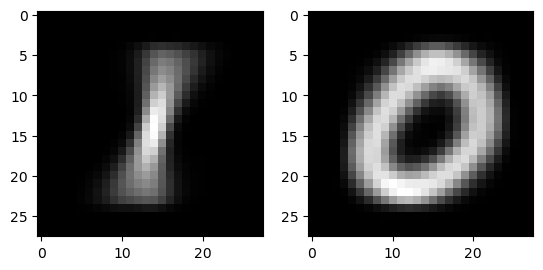

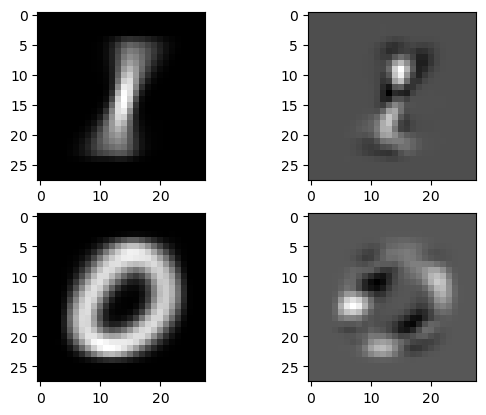

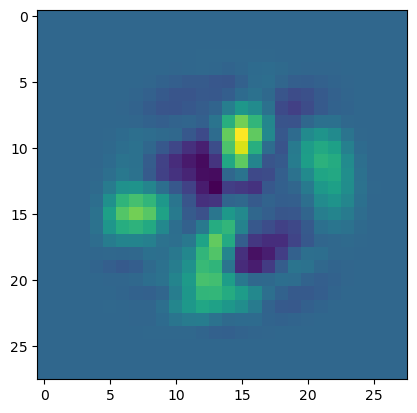

In [35]:
mean_c1 = torch.mean(torch.stack(imgs_c1),axis=0)
mean_c2 = torch.mean(torch.stack(imgs_c2),axis=0)


fig1, ax1 = plt.subplots(1, 2)

ax1[0].imshow(mean_c1.permute(1, 2, 0).to('cpu'), cmap='gray')
ax1[1].imshow(mean_c2.permute(1,2,0).to('cpu'), cmap='gray')

attr1, delta1 = ig.attribute(mean_c1.unsqueeze(0), target=class1, return_convergence_delta=True)
attr2, delta2 = ig.attribute(mean_c2.unsqueeze(0), target=class2, return_convergence_delta=True)


fig,ax = plt.subplots(2,2)
ax[0,0].imshow(mean_c1.permute(1, 2, 0).to('cpu'), cmap='gray')
ax[0,1].imshow(attr1[0][0].detach().to('cpu').numpy(), cmap='gray')

ax[1,0].imshow(mean_c2.permute(1, 2, 0).to('cpu').numpy(), cmap='gray')
ax[1,1].imshow(attr2[0][0].detach().to('cpu').numpy(), cmap='gray')

fig,ax = plt.subplots()
ax.imshow(attr2[0][0].detach().to('cpu').numpy()+attr1[0][0].detach().to('cpu').numpy())

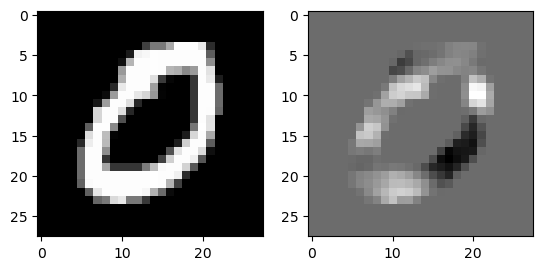

In [36]:
from captum.attr import GradientShap


# Instantiate an IntegratedGradients object for the model
gs = GradientShap(model_lenet5_v1_mnist_loaded)

# Compute the attribution scores for the random image
attr, delta = gs.attribute(img.unsqueeze(0),baselines=torch.zeros(1,1,28,28), target=label, return_convergence_delta=True)

# Visualize the attribution scores
fig, ax = plt.subplots(1, 2)

ax[0].imshow(img.permute(1, 2, 0).to('cpu'), cmap='gray')
ax[1].imshow(attr[0][0].detach().to('cpu').numpy(), cmap='gray')

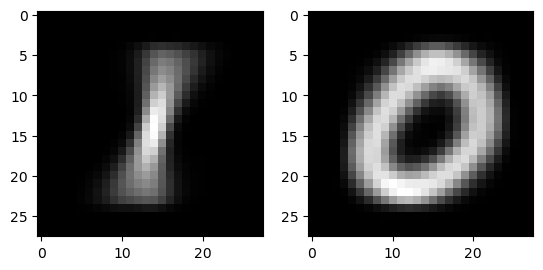

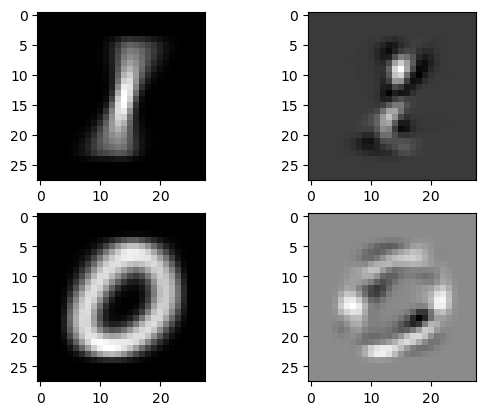

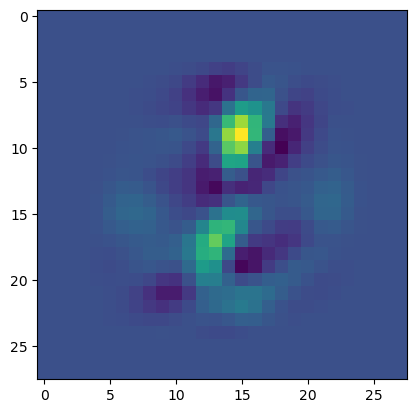

In [37]:
fig1, ax1 = plt.subplots(1, 2)

ax1[0].imshow(mean_c1.permute(1, 2, 0).to('cpu'), cmap='gray')
ax1[1].imshow(mean_c2.permute(1,2,0).to('cpu'), cmap='gray')

attr1_GS, delta1 = gs.attribute(mean_c1.unsqueeze(0),baselines=torch.zeros(1,1,28,28), target=class1, return_convergence_delta=True)
attr2_GS, delta2 = gs.attribute(mean_c2.unsqueeze(0),baselines=torch.zeros(1,1,28,28), target=class2, return_convergence_delta=True)


fig,ax = plt.subplots(2,2)
ax[0,0].imshow(mean_c1.permute(1, 2, 0).to('cpu'), cmap='gray')
ax[0,1].imshow(attr1_GS[0][0].detach().to('cpu').numpy(), cmap='gray')

ax[1,0].imshow(mean_c2.permute(1, 2, 0).to('cpu').numpy(), cmap='gray')
ax[1,1].imshow(attr2_GS[0][0].detach().to('cpu').numpy(), cmap='gray')

fig,ax = plt.subplots()
ax.imshow(attr2_GS[0][0].detach().to('cpu').numpy()+attr1_GS[0][0].detach().to('cpu').numpy())

c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


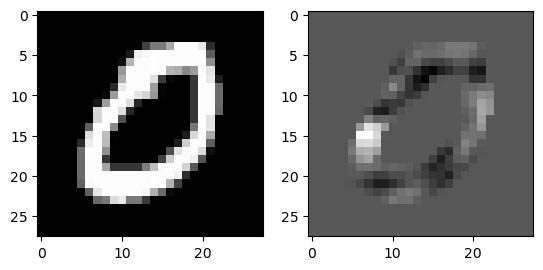

In [20]:
from captum.attr import DeepLift


# Instantiate an IntegratedGradients object for the model
dl = DeepLift(model_lenet5_v1_mnist_loaded)

# Compute the attribution scores for the random image
attr = dl.attribute(img.unsqueeze(0), target=label)

# Visualize the attribution scores
fig, ax = plt.subplots(1, 2)

ax[0].imshow(img.permute(1, 2, 0).to('cpu'), cmap='gray')
ax[1].imshow(attr[0][0].detach().to('cpu').numpy(), cmap='gray')

c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


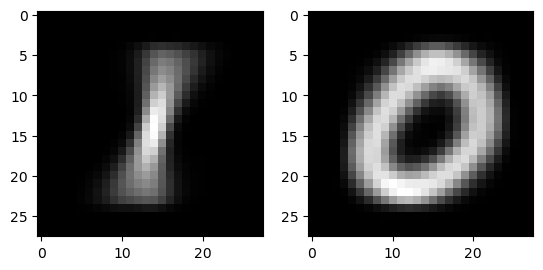

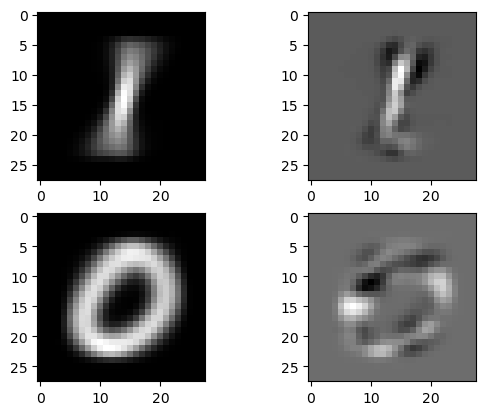

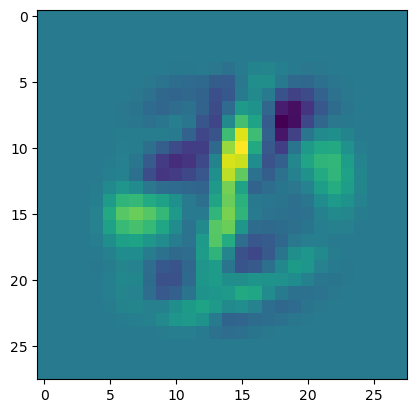

In [38]:
fig1, ax1 = plt.subplots(1, 2)

ax1[0].imshow(mean_c1.permute(1, 2, 0).to('cpu'), cmap='gray')
ax1[1].imshow(mean_c2.permute(1,2,0).to('cpu'), cmap='gray')

attr1_DL = dl.attribute(mean_c1.unsqueeze(0), target=class1)
attr2_DL = dl.attribute(mean_c2.unsqueeze(0), target=class2)


fig,ax = plt.subplots(2,2)
ax[0,0].imshow(mean_c1.permute(1, 2, 0).to('cpu'), cmap='gray')
ax[0,1].imshow(attr1_DL[0][0].detach().to('cpu').numpy(), cmap='gray')

ax[1,0].imshow(mean_c2.permute(1, 2, 0).to('cpu').numpy(), cmap='gray')
ax[1,1].imshow(attr2_DL[0][0].detach().to('cpu').numpy(), cmap='gray')

fig,ax = plt.subplots()
ax.imshow(attr2_DL[0][0].detach().to('cpu').numpy()+attr1_DL[0][0].detach().to('cpu').numpy())

SWD: 0.07521274208356983
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.   

c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMe

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.  

c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMe

SWD: 0.05325034854345861
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.   

c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMe

SWD: 0.043428873910949385
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.  

c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMe

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMe

SWD: 0.030593512332434996
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.  

c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMe

SWD: 0.025497857458075507
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.  

c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMe

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.  

c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMe

SWD: 0.016034410879120872
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.  

c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMe

SWD: 0.01262007228952926
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.   

c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


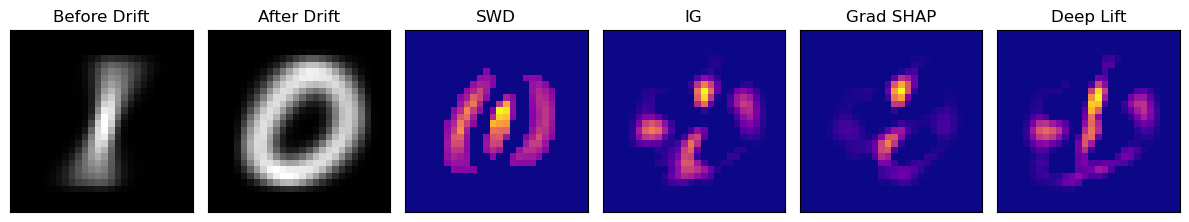

In [40]:
from utils import *

replace_negatives = np.vectorize(lambda x: 0 if x < 0 else x)

rf,_,SWDs = remove_important_features(mean_c1.unsqueeze(0).to('cpu').numpy()[0,0,:,:].reshape(1,784),mean_c2.unsqueeze(0).to('cpu').numpy()[0,0,:,:].reshape(1,784),150,10000)


Features = np.zeros(784)
f_id = []
contributions = []
k=1
for d in rf:
    i = d["removed_feature"]
    #Features[i] = 1/(1+k**(1/2))
    Features[i] = 1/(np.log(k+1))
    k+=0.075
    f_id.append(i)
    contributions.append(d['contribution_value'])


fig,ax = plt.subplots(1,6,figsize=(12,4))
ax[0].set_title('Before Drift')
ax[0].imshow(mean_c1.permute(1, 2, 0).to('cpu'), cmap='gray')
ax[1].set_title('After Drift')
ax[1].imshow(mean_c2.permute(1, 2, 0).to('cpu'), cmap='gray')
#ax[0].imshow(X_img,cmap=plt.cm.gray)
#ax[1].imshow(Y_img,cmap=plt.cm.gray)
ax[2].set_title('SWD')
ax[2].imshow(np.float64(Features.reshape(28,28)),cmap='plasma')
ax[3].imshow(replace_negatives(attr1[0][0].detach().to('cpu').numpy()+attr2[0][0].detach().to('cpu').numpy()),cmap='plasma')
#ax[3].imshow(np.abs(attr1[0][0].detach().to('cpu').numpy()-attr2[0][0].detach().to('cpu').numpy()),cmap='plasma')
ax[3].set_title('IG')
ax[4].imshow(replace_negatives(attr1_GS[0][0].detach().to('cpu').numpy()+attr2_GS[0][0].detach().to('cpu').numpy()),cmap='plasma')
#ax[4].imshow(np.abs(attr1_GS[0][0].detach().to('cpu').numpy()-attr2_GS[0][0].detach().to('cpu').numpy()),cmap='plasma')
ax[4].set_title('Grad SHAP')
ax[5].imshow(replace_negatives(attr1_DL[0][0].detach().to('cpu').numpy()+attr2_DL[0][0].detach().to('cpu').numpy()),cmap='plasma')
#ax[5].imshow(np.abs(attr1_DL[0][0].detach().to('cpu').numpy())+np.abs(attr2_DL[0][0].detach().to('cpu').numpy()),cmap='plasma')

#ax[5].imshow(np.abs(attr1_DL[0][0].detach().to('cpu').numpy()-attr2_DL[0][0].detach().to('cpu').numpy()),cmap='plasma')
ax[5].set_title('Deep Lift')

for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
#ax[5].imshow(np.abs(Features.reshape(28,28)-(attr2_GS[0][0].detach().to('cpu').numpy()+attr1_GS[0][0].detach().to('cpu').numpy())),cmap='plasma')
fig.tight_layout()

In [57]:
fig.savefig('MNIST_example0-8.pdf')

In [34]:
model_lenet5_v1_mnist_loaded.feature[-3]

Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))

c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


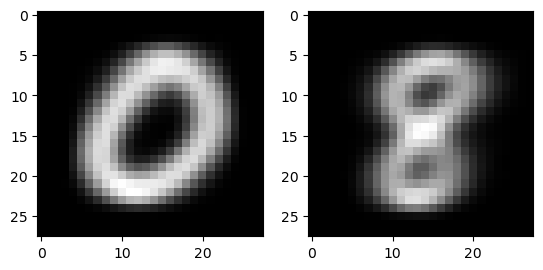

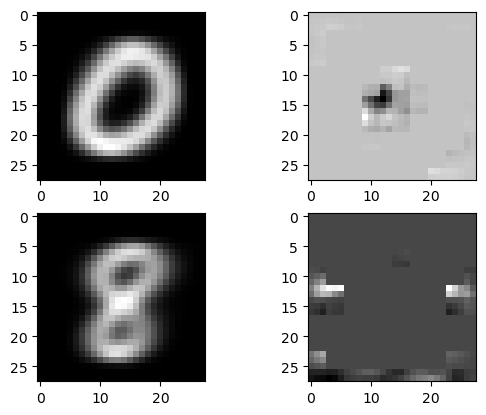

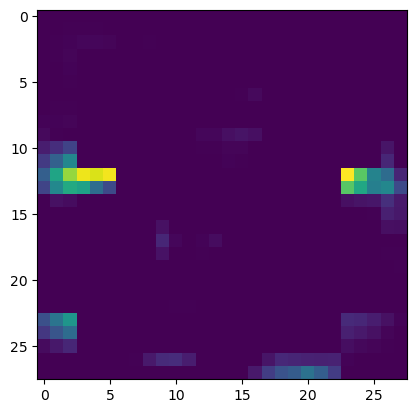

In [45]:
from captum.attr import GuidedGradCam



gc = GuidedGradCam(model_lenet5_v1_mnist_loaded,model_lenet5_v1_mnist_loaded.feature[-3])


fig1, ax1 = plt.subplots(1, 2)

ax1[0].imshow(mean_c1.permute(1, 2, 0).to('cpu'), cmap='gray')
ax1[1].imshow(mean_c2.permute(1,2,0).to('cpu'), cmap='gray')

attr1_GC = gc.attribute(mean_c1.unsqueeze(0), target=class1)
attr2_GC = gc.attribute(mean_c2.unsqueeze(0), target=class2)


fig,ax = plt.subplots(2,2)
ax[0,0].imshow(mean_c1.permute(1, 2, 0).to('cpu'), cmap='gray')
ax[0,1].imshow(attr1_GC[0][0].detach().to('cpu').numpy(), cmap='gray')

ax[1,0].imshow(mean_c2.permute(1, 2, 0).to('cpu').numpy(), cmap='gray')
ax[1,1].imshow(attr2_GC[0][0].detach().to('cpu').numpy(), cmap='gray')

fig,ax = plt.subplots()
ax.imshow(replace_negatives(attr2_GC[0][0].detach().to('cpu').numpy()+attr1_GC[0][0].detach().to('cpu').numpy()))